In [ ]:
from util_fdp import *
import numpy as np
import matplotlib.pyplot as plt


n_clients = 10
E_typ = 'cons'
# 获取单次训练的轨迹
trajectory = run_federated_trajectory(
    dist_type='normal', 
    tau=0.5, 
    client_rs=[0.25] * n_clients, 
    n_clients=n_clients, 
    T=50000, 
    E_typ=E_typ, 
    E_cons=1, 
    gene_process='homo', 
    mode='federated',
    base_seed=2025,
    a=0.51, b=100,c=20
)

In [48]:
# 分析轨迹数据
client_0_history = trajectory['local']['client_0']
global_q_avg_history = trajectory['global']['global_q_avg']
global_variance_history = trajectory['global']['global_variance']
z_score = 6.753 if E_typ == 'log' else 6.74735

# 将字典转换为有序的数组
sample_num = sorted(global_q_avg_history.keys())
q_avg_values = np.array([global_q_avg_history[k] for k in sample_num])
variance_values = np.array([global_variance_history[k] for k in sample_num])

# 计算置信区间
lower_bound = q_avg_values - z_score * np.sqrt(variance_values)
upper_bound = q_avg_values + z_score * np.sqrt(variance_values)


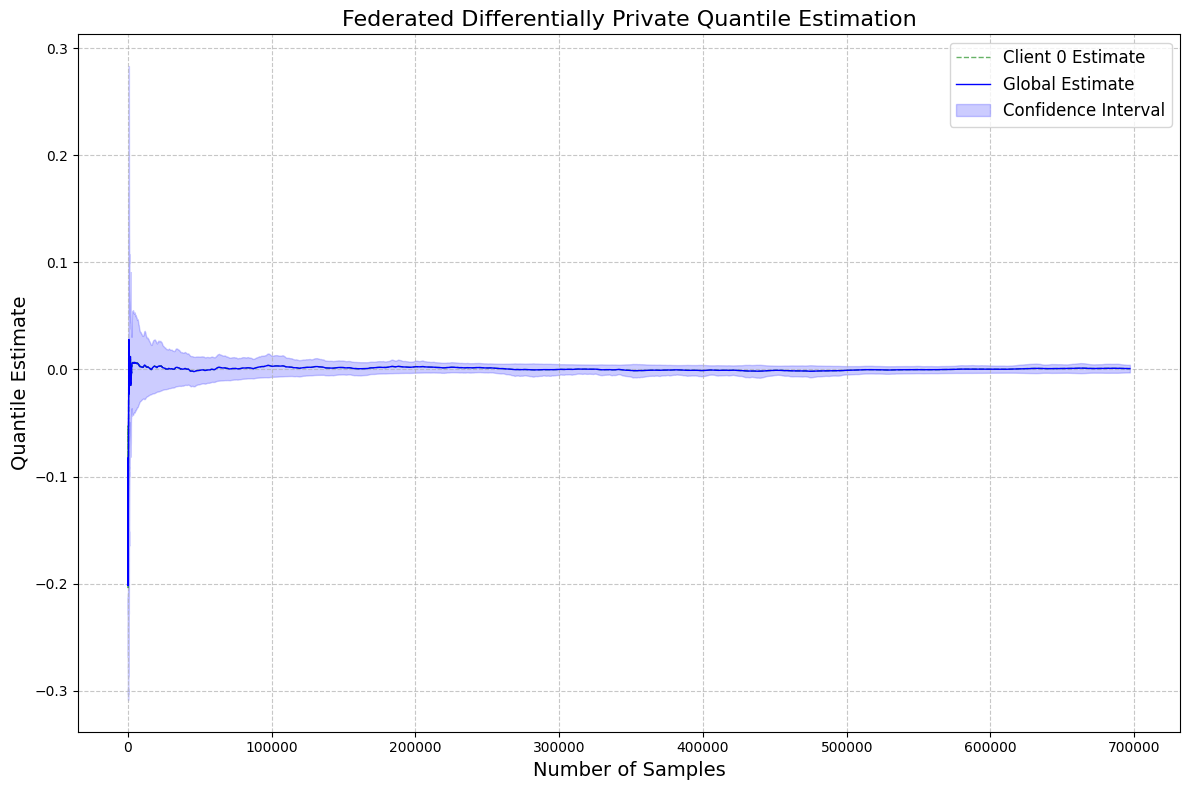

In [49]:
# 创建图形
plt.figure(figsize=(12, 8))

# 绘制全局估计值和客户端估计值
if client_0_history:  # 如果有客户端历史记录
    client_samples = sorted(client_0_history.keys())
    client_values = [client_0_history[k] for k in client_samples]
    plt.plot(client_samples, client_values, 'g--', linewidth=1, label='Client 0 Estimate', alpha=0.6)

# 绘制全局估计值
plt.plot(sample_num, q_avg_values, 'b-', linewidth=1, label='Global Estimate')

# 绘制置信区间
plt.fill_between(sample_num, lower_bound, upper_bound, 
                 color='blue', alpha=0.2, 
                 label='Confidence Interval')

# 设置图表属性
plt.title('Federated Differentially Private Quantile Estimation', fontsize=16)
plt.xlabel('Number of Samples', fontsize=14)
plt.ylabel('Quantile Estimate', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)


# 调整布局并显示图形
plt.tight_layout()
plt.show()